This Jupyter Notebook is a basic guide to exploratory data analysis using Python Language, SQL Language and SQLite Database, provided by the "Python Fundamentals of Data Analysis 3.0" course offered by the Data Science Academy. Actual publicly available data, movie data on IMDB will be used.
By applying Exploratory Data Analysis it will be possible to answer these 10 questions:

1- What are the Most Common Movie Categories on IMDB?
2- What is the number of titles by genre?
3- What is the Median Rating of Films by Genre?
4- What is the Median Evaluation of Films Regarding the Year of Premiere?
5- What is the number of films evaluated by genre in relation to the year of debut?
6- What is the longest running movie? Calculate the percentiles.
7- What is the relationship between duration and genre?
8- What is the number of films produced per country?
9- What are the Top 10 Best Movies?
10- What are the Top 10 Worst Movies?

In [1]:
from platform import python_version
print('Versão da linguagem python usada neste jupyter notebook', python_version()) 

Versão da linguagem python usada neste jupyter notebook 3.9.7


In [2]:
#instalando o pacote destinado a trazer de forma organizada os dados contidos na plataforma IMDB
!pip install imdb-sqlite

In [3]:
#instalando o pacote que decodifica o padrão ISO as siglas nos nomes dos países
!pip install pycountry 

In [4]:
#Importando pacotes necessários para as análises, visualizaçoes e outros.

#expressão regulares
import re 
#medir tempo de execução ou manipular datas
import time 
#trbalhar com o banco de dados SQLite
import sqlite3 
#decodificar nom de países
import pycountry 
#manipulação de dados
import numpy as np 
#manipulação de dados
import pandas as pd 
#vizualização de dados
import matplotlib.pyplot as plt
#vizualização de dados
import seaborn as sns 
#vizualização de dados
from matplotlib import cm 
#machine learning
from sklearn.feature_extraction.text import CountVectorizer 
#filtrar warnings
import warnings 
warnings.filterwarnings("ignore") 
#define um padrão de fundo branco para os gráficos
sns.set_theme(style = "whitegrid") 

Carregando os dados

In [5]:
%%time
#download dos arquivos com os dados e criar um banco de dados
!imdb-sqlite 

Wall time: 449 ms


2022-03-15 14:31:45,704 DB already exists: (imdb.db). Refusing to modify. Exiting


In [6]:
#conectar ao banco de dados criado através do pacote imdb 
conn = sqlite3.connect("imdb.db")

In [7]:
#extrair a lista de tabelas que estão no banco
tabelas = pd.read_sql_query("SELECT name AS 'Table_Name' FROM sqlite_master WHERE type = 'table'",conn)

In [8]:
#verificar o tipo do objeto
type(tabelas)

pandas.core.frame.DataFrame

In [9]:
#vizualizar os resultados
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [10]:
#convertendo a tabela de nomes e uma lista para facilitar a vizualição
tabelas = tabelas["Table_Name"].values.tolist()

tabelas

['people', 'titles', 'akas', 'crew', 'episodes', 'ratings']

In [11]:
#extrair o schema de cada tabela para conhecer os tipos de dados  e como eles estão organizados

for tabela in tabelas:
    #"PRAGMA TABLE_INFO({})" usado no SQLite extrai as informações da tabela 
    consulta= "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela: ",tabela)
    #display vizualiza o resultado
    display(resultado)
    print("-"*100)
    print("\n")
    

Esquema da tabela:  people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




Análise exploratória dos dados

1 - Quais são as categorias de títulos (filmes) mais comuns no IMDB?

In [12]:
#Usando uma query SQL é possivel retornar as categorias com mais ocorrências dentro do banco de dados
#GROUP BY permite aplicar funções de agregação, como COUNT(), em grupos, neste exemplo, a query ira realizar a contagem de todos os elementos em cada grupo de categorias

consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type ORDER BY COUNT DESC'''

In [13]:
#executar a query
resultado1 = pd.read_sql_query(consulta1, conn)

In [14]:
#vizualizar o resultado
display(resultado1)

,type,COUNT
0,tvEpisode,6529442
1,short,857667
2,movie,603031
3,video,257675
4,tvSeries,221595
5,tvMovie,135112
6,tvMiniSeries,42258
7,tvSpecial,36047
8,videoGame,30513
9,tvShort,10463


In [15]:
#adicionando uma coluna com o percentual em relação ao total
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) *100

In [16]:
#vizualizar o resultado
display(resultado1)

,type,COUNT,percentual
0,tvEpisode,6529442,74.846263
1,short,857667,9.831341
2,movie,603031,6.912477
3,video,257675,2.953700
4,tvSeries,221595,2.540119
5,tvMovie,135112,1.548774
6,tvMiniSeries,42258,0.484399
7,tvSpecial,36047,0.413203
8,videoGame,30513,0.349767
9,tvShort,10463,0.119936


In [17]:
#Consolidando um pouco mais, seria possivel condençar a tabela em apenas 4 categorias, as 3 maiores e as demais em "outros"
#Para isso, um dicionário poderia armazenar a nova categoria, inicialmente, devido ao seu carater de chave-valor

others = {}

#filtra o percentual que esta abaixo de 5% e soma o total destes
others['COUNT'] = resultado1[resultado1['percentual']<5]['COUNT'].sum()

#gravando o percentual
others['percentual'] = resultado1[resultado1['percentual']<5]['percentual'].sum()

#ajusta o nome na tabela 
others['type']= 'others'



In [18]:
#vizualizando o resultado
others

{'COUNT': 733665, 'percentual': 8.409919754052275, 'type': 'others'}

In [19]:
#filtra o dataframe com as categorias com mais de 5% de ocorrencias para montar o resultado 
resultado1 = resultado1[resultado1['percentual']>5]

In [20]:
#append com o dataframe "others"
resultado1 = resultado1.append(others, ignore_index= True)

In [21]:
#testando
display(resultado1)

,type,COUNT,percentual
0,tvEpisode,6529442,74.846263
1,short,857667,9.831341
2,movie,603031,6.912477
3,others,733665,8.409920


In [22]:
#ordenando a partir do numero de ocorrências "COUNT"
resultado1 = resultado1.sort_values(by = 'COUNT', ascending= False)

In [23]:
#visualizando
resultado1.head()

,type,COUNT,percentual
0,tvEpisode,6529442,74.846263
1,short,857667,9.831341
3,others,733665,8.409920
2,movie,603031,6.912477


In [24]:
#para tornar a visualização ainda mais eficiente, criar um gráfico pode ser uma boa opção
#ajustando as labels
#abaixo temos o uso de uma list comprehension, que consiste em usar um loop e suas instruções dentro de um unico comando, leia-se do final para o inicio: para cada item em "resultado1", transforme em string o seu respectivo "type", concatene com um espaco em branco, junto do percentual arredondado em duas casas
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2))+'%'+']' for i in resultado1.index]



<function matplotlib.pyplot.show(close=None, block=None)>

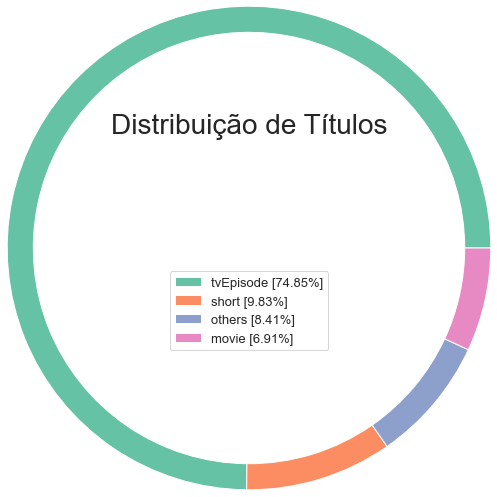

In [25]:
#montando o gráfico
#selecionando o mapa de cores
cs = cm.Set2(np.arange(100))

#plt.figure é responsavel por tornar acessivel as metricas da figura (entenda figura como o espaço de visualização, uma "janela" que será configurada para mostrar "plt.show"), editar parametros originais
f = plt.figure

#configurando o grafico de pizza
#plt.pie seleciona o modelo de grafico de pizza, tendo como primeiro parametro qual serao os dados a serem representados, após, "labeldistance", que eu ainda nao descobri o que é, "radius" seria o tamanho em rad da circunferência, "colors", obviamente, esquema de cores a serem utilizados, "wedgeprops", proporção das paredes de cada fatia, em "none", temso um grafico com as paredes totalmentes unidas no centro, com dict(width = x) teremos a distancia x do centro, formando um grafico rosca
plt.pie(resultado1['COUNT'], labeldistance= 1, radius= 2.78, colors= cs, wedgeprops= dict(width = 0.3))
#plt.legend aplica as legendas de forma separada ao grafico em si (ou seja, permite maior customização por estar em outro parametro). "labels" seria o titulo de cada fatia, neste caso, os types com suas porcentagens, "loc", localização da legenda na no grafico, "prop", edita os parametrso de tamanho da legenda
plt.legend(labels = labels, loc = 'lower center', prop = {'size':13})
#plt.title permite editar parametros do titulo do grafico, primeiro valor temso o titulo, "loc", mais uma vez se refere a localização da string, "fontdict" edita metricas da string, como peso e tamanho
plt.title("Distribuição de Títulos", loc = 'center', fontdict={'fontsize' : 28, 'fontweight':20})
#plt.show apresenta o grafico sem retornos do matplotlib, como os parametros internos
plt.show


2 - Qual a quantidade de filmes por gênero?


In [26]:
#Para ter acesso a estes dados, uma consulta SQL pode resolver
consulta2 = '''SELECT genres, COUNT(*) AS COUNT FROM titles WHERE type = 'movie' GROUP BY genres ORDER BY COUNT DESC'''



In [27]:
#testando
resultado2 = pd.read_sql_query(consulta2,conn)

In [28]:
#visualizando
display(resultado2)

,genres,COUNT
0,Drama,111593
1,Documentary,85341
2,\N,71425
3,Comedy,43163
4,Horror,14783
...,...,...
1446,"Action,Adult,Western",1
1447,"Action,Adult,Sci-Fi",1
1448,"Action,Adult,Horror",1
1449,"Action,Adult,Fantasy",1


In [29]:
#é possivel observar que existem valores com erro, "\N", estem devem ser removidos para uma melhor análise
#vamos padronizar os nomes de cda genero para melhor manipulação
resultado2['genres'] = resultado2['genres'].str.lower().values

In [30]:
#testando
display(resultado2)

,genres,COUNT
0,drama,111593
1,documentary,85341
2,\n,71425
3,comedy,43163
4,horror,14783
...,...,...
1446,"action,adult,western",1
1447,"action,adult,sci-fi",1
1448,"action,adult,horror",1
1449,"action,adult,fantasy",1


In [31]:
#antes de limpar, vamso adicionar a coluna de porcentagem
resultado2['percentual'] = resultado2['COUNT']/resultado2['COUNT'].sum() *100

In [32]:
#visualizando
display(resultado2)

,genres,COUNT,percentual
0,drama,111593,18.505350
1,documentary,85341,14.152009
2,\n,71425,11.844333
3,comedy,43163,7.157675
4,horror,14783,2.451449
...,...,...,...
1446,"action,adult,western",1,0.000166
1447,"action,adult,sci-fi",1,0.000166
1448,"action,adult,horror",1,0.000166
1449,"action,adult,fantasy",1,0.000166


In [33]:
#para retirar os valores com erro, valores NA, usamos um recurso da lib pandas, e vamos armazenar em uma variavel temporaria
temp = resultado2['genres'].dropna()

In [34]:
#Outra forma de contar e organizar, seria usar o countvectorizer, que transfomará a coluna de 'genres' em uma matriz one-hot encoded, principalmente usada em dados categoricos
#para podermos manipular strings, organizar as categorias dos títulos e coisas assim, temso que usar expressões regulares
#uma expressão regular é caracterizada por permitir a localização e manipulação de string a partir de um padrão, este deve ser codificado
#no caso abaixo:
# '()' seria um forma de ordenar multiplas REGEX, logo, a primeira expressão a ser processada sera a que estiver dentros dos parenteses
# "?u", que seria: "?" referenciando a instrução "re."", e "u" correspondencia ao formato unicode
#"\b", representa espaço em branco, e "\bpalavra\b" sinaliza somente "palavra" em seu formato inteiriço, somente palavras inteiras, tendo no inicio e no final espaços em branco (espaço entre caractres)
#"[]", indica os caracteres a serem trabalhados
#"\w" simboliza caracteres em palavras
#"+" permite uma ou mais ocorrências
padrao = '(?u)\\b[\\w]+\\b'



In [35]:
#para fins de conhecimento, podemos usar a função countvectorizer do pacote sklearn.
#CountVectorizer transforma docuemntos de texto uma matriz esparsa com o vocabulário dele, sinalizando o numero de ocorrências de cada elemento. Costuma ser usado em ambientes de ML para treinar modelos
#neste exemplo temos o padrão a ser analizado dentro do documento "padrao", a regez feita anteriormente, e o tipo de elemento a ser analisado, neste caso, palavra por palavra, e, em seguida, o arquivo a ser lido.
#mas neste momento, este comando apenas "treina" o vetor, precisamos aplicar posteriormente
vetor = CountVectorizer(token_pattern= padrao, analyzer='word').fit(temp)

In [36]:
#verificando o tipo do vetor
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [37]:
#aplicando a vetorização
bag_genres = vetor.transform(temp)

In [38]:
#verificando o tipo
type(bag_genres)

scipy.sparse.csr.csr_matrix

In [40]:
#vamos retornar apenas os generos unicos, extraindo o nome das colunas da matrix esparsa (que são as palavras distintas no documento)
generos_unicos = vetor.get_feature_names()

In [41]:
#criando um dataframe de generos
#pd.dataframe possui como primeiro parametro a fonte de dados, neste caso seria a bolsa de generos tranformada em uma matriz, com as colunas sendo dos genros unicos, com a indexação do arquivo temp
generos = pd.DataFrame(bag_genres.todense(), columns = generos_unicos, index= temp.index)

In [42]:
#visualizando
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1450
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1451 non-null   int64
 1   adult        1451 non-null   int64
 2   adventure    1451 non-null   int64
 3   animation    1451 non-null   int64
 4   biography    1451 non-null   int64
 5   comedy       1451 non-null   int64
 6   crime        1451 non-null   int64
 7   documentary  1451 non-null   int64
 8   drama        1451 non-null   int64
 9   family       1451 non-null   int64
 10  fantasy      1451 non-null   int64
 11  fi           1451 non-null   int64
 12  film         1451 non-null   int64
 13  game         1451 non-null   int64
 14  history      1451 non-null   int64
 15  horror       1451 non-null   int64
 16  music        1451 non-null   int64
 17  musical      1451 non-null   int64
 18  mystery      1451 non-null   int64
 19  n            1451 non-null   int64
 20  news    

In [43]:
#retirando a coluna "n"
#selecionamos a coluna a partir de "columns" e o eixo a ser excluido, 0 para coluna e 1 para linha
generos = generos.drop(columns='n', axis=0)

In [46]:
#calculando o percentual de cada genero
#pd.series captura o elemento de cada rotulo, parecido com o GROUP BY, principalmente para realizar operações .sort_values organiza os dados, de forma ascendente ou nao, shape[0] retorna o numero de linhas, e 1, o numero de colunas
#como estamos lidando com uma matriz esparsa, nosso método de calcular a porcentagem difere um pouco do comum, precisamos somar a qunatidade de vezes que um genero apareceu, exemplo, ação, é uma palavra unica que representa um gênero, dentro mais de 1400, segundo o dataframe, logo basta somarmos quantas vezes acção apareceu e dividir pelo total de generos, que neste caso seria o total de linhas, ja que na matriz esparsa as linhas representam as entradas de dados. Teriamos apenas uma linha caso os genros fossem dispostos em apenas uma linha, mas como viemos de uma tabela, cada rótulo se tornou uma entrada.
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [48]:
#visualizando o resultado
generos_percentual.head(15)

drama          18.194349
comedy         16.815989
documentary    15.851137
adventure      14.817367
action         14.403859
romance        13.370090
crime          13.094418
mystery        12.474156
thriller       12.336320
fantasy        12.198484
horror         11.991730
history        11.716058
family         11.302550
fi             11.164714
sci            11.164714
dtype: float64

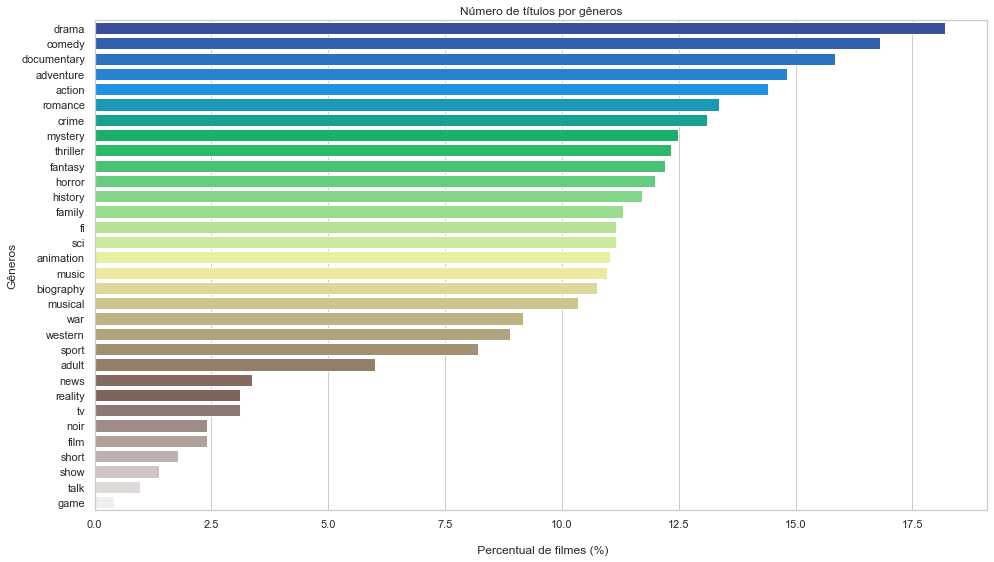

In [67]:
#montando um grafico com seaborn
#primeiro passo é definir o tamanho do campo disponivel para o gráfico, com "figure'
#diferente do primeiro caso, neste nao especificamos o arquivo todo, mas os dados dele para a plotagem, x indica o que sera mostrado no eixo x, e y os elemnetos na vertical, index são os rotulos, e values os valores
plt.figure(figsize=(16,9))
sns.barplot(x=generos_percentual.values, y=generos_percentual.index, palette = 'terrain')
#aqui temos a nomeação do gráfico e dos eixos
plt.xlabel("\n Percentual de filmes (%)")
plt.ylabel("Gêneros")
plt.title("Número de títulos por gêneros")
plt.show()







